# Regression Script
## Random Forest for Remote Sensing Data

### Florian Beyer

2020-02-21

In [1]:
# Requried Packages
from osgeo import gdal, ogr, gdal_array # I/O image data
import numpy as np # math and array handling
import matplotlib.pyplot as plt # plot figures
import pandas as pd # handling large data as table sheets

from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import AdaBoostRegressor
#from sklearn import svm
#from sklearn.kernel_ridge import KernelRidge
#from sklearn.model_selection import GridSearchCV
#from sklearn.cross_decomposition import PLSRegression
#from sklearn.gaussian_process import GaussianProcessRegressor

from joblib import dump, load

# Tell GDAL to throw Python exceptions, and register all drivers
gdal.UseExceptions()
gdal.AllRegister()



In [2]:
# data input

# define a number of trees that should be used (default = 500)
est = 500

# the remote sensing image you want to classify
img_RS = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\stack_all_data_tif.tif'

# training and validation
#    as image in the same extand as your remote sensing image
#    no data pixels = 0 or negative
#    class pixels > 0 and as integer
field = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Daten\\biomasse_all.shp'


# what is the attributes name of your classes in the shape file (field name of the classes)?
attribute = 'FM_in_Gram'


# save path, predicted image
prediction_map = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\prediction_map.tif'


# save path, trained model
save_model = 'D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\RFR.joblib'


In [3]:
# Data preparation

# load image data

img_ds = gdal.Open(img_RS, gdal.GA_ReadOnly)

img = np.zeros((img_ds.RasterYSize, img_ds.RasterXSize, img_ds.RasterCount),
               gdal_array.GDALTypeCodeToNumericTypeCode(img_ds.GetRasterBand(1).DataType))
for b in range(img.shape[2]):
    img[:, :, b] = img_ds.GetRasterBand(b + 1).ReadAsArray()

In [4]:
# Data preparation
# load training data from shape file

#model_dataset = gdal.Open(model_raster_fname)
shape_dataset = ogr.Open(field)
shape_layer = shape_dataset.GetLayer()
mem_drv = gdal.GetDriverByName('MEM')
mem_raster = mem_drv.Create('',img_ds.RasterXSize,img_ds.RasterYSize,1,gdal.GDT_UInt16)
mem_raster.SetProjection(img_ds.GetProjection())
mem_raster.SetGeoTransform(img_ds.GetGeoTransform())
mem_band = mem_raster.GetRasterBand(1)
mem_band.Fill(0)
mem_band.SetNoDataValue(0)

att_ = 'ATTRIBUTE='+attribute
# http://gdal.org/gdal__alg_8h.html#adfe5e5d287d6c184aab03acbfa567cb1
# http://gis.stackexchange.com/questions/31568/gdal-rasterizelayer-doesnt-burn-all-polygons-to-raster
err = gdal.RasterizeLayer(mem_raster, [1], shape_layer, None, None, [1],  [att_,"ALL_TOUCHED=TRUE"])
assert err == gdal.CE_None

roi = mem_raster.ReadAsArray()


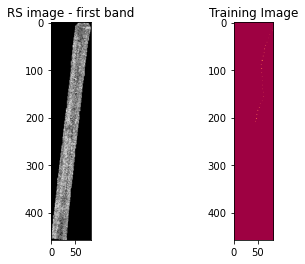

In [5]:
# Display image and Training data

plt.subplot(121)
plt.imshow(img[:, :, 0], cmap=plt.cm.Greys_r)
plt.title('RS image - first band')

plt.subplot(122)
plt.imshow(roi, cmap=plt.cm.Spectral)
plt.title('Training Image')

plt.show()


In [6]:
# Number of training pixels:
n_samples = (roi > 0).sum()
print('We have {n} training samples'.format(n=n_samples))

We have 25 training samples


In [7]:
# Subset the image dataset with the training image = X
# Mask the classes on the training dataset = y
# These will have n_samples rows
X = img[roi > 0, :]
y = roi[roi > 0]


In [8]:
print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

Our X matrix is sized: (25, 19)
Our y array is sized: (25,)


In [13]:
RFR = RandomForestRegressor(bootstrap=True,
                             criterion='mse',
                             max_depth=None,
                             max_features='auto',
                             max_leaf_nodes=None,
                             min_impurity_decrease=0.0,
                             min_impurity_split=None,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             min_weight_fraction_leaf=0.0,
                             n_estimators=500,
                             n_jobs=-1, # using all cores
                             oob_score=True,
                             random_state=0,
                             verbose=1,
                             warm_start=False)
RFR.fit(X,y)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=-1, oob_score=True,
                      random_state=0, verbose=1, warm_start=False)

In [14]:
# Regression R^2 -> coefficient of determination
RFR.score(X,y)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.0s finished


0.9088030031997921

In [15]:
# save the regression model to disk

# Save
dump(RFR, save_model)

# load model:
#RFR = load(save_model)

['D:\\OwnCloud\\WetScapes\\2020_02_21_Regression_Biomass\\Results\\RFR.joblib']

In [16]:
#print(RFR.estimators_)
#print(RFR.feature_importances_)
#print(RFR.n_features_)
#print(RFR.n_outputs_)
#print(RFR.oob_score_)
print(RFR.oob_prediction_)

[119.68253968 155.45977011 168.35294118 157.95698925 163.
 255.34090909 409.49238579 379.88095238 342.72727273 363.90374332
 420.58510638 331.66666667 288.40206186 159.74522293 186.30681818
 129.23976608 154.         131.39664804 151.22093023 187.78350515
 244.52631579 282.06451613 591.8452381  505.87209302 431.71122995]


[119.68253968 155.45977011 168.35294118 157.95698925 163.
 255.34090909 409.49238579 379.88095238 342.72727273 363.90374332
 420.58510638 331.66666667 288.40206186 159.74522293 186.30681818
 129.23976608 154.         131.39664804 151.22093023 187.78350515
 244.52631579 282.06451613 591.8452381  505.87209302 431.71122995]
[160.0, 150.0, 70.0, 180.0, 270.0, 380.0, 250.0, 320.0, 790.0, 270.0, 510.0, 230.0, 140.0, 140.0, 180.0, 160.0, 150.0, 190.0, 130.0, 170.0, 330.0, 420.0, 380.0, 610.0, 250.0]


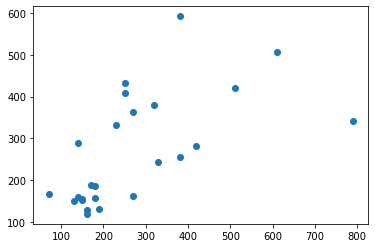

In [17]:
pred1 = np.array(RFR.oob_prediction_)
obs = np.array(y)
obs = [np.float(i) for i in obs]

print(pred1)
print(obs)
fig,ax = plt.subplots()
ax.scatter(obs,pred1)
plt.show()

In [39]:
# band importances

for i in range(len(RFR.feature_importances_)):
    importance = round(RFR.feature_importances_[i]*100,2)
    print('Band {}: {}'.format(i+1, importance))

Band 1: 3.08
Band 2: 3.31
Band 3: 2.19
Band 4: 13.73
Band 5: 0.69
Band 6: 0.95
Band 7: 1.17
Band 8: 6.92
Band 9: 16.08
Band 10: 0.76
Band 11: 0.79
Band 12: 2.94
Band 13: 15.36
Band 14: 1.7
Band 15: 3.51
Band 16: 5.73
Band 17: 4.27
Band 18: 14.78
Band 19: 2.04


In [40]:
# Predicting the rest of the image

# Take our full image and reshape into long 2d array (nrow * ncol, nband) for classification
new_shape = (img.shape[0] * img.shape[1], img.shape[2])
img_as_array = img[:, :, :].reshape(new_shape)

print('Reshaped from {o} to {n}'.format(o=img.shape, n=img_as_array.shape))

img_as_array = np.nan_to_num(img_as_array)

Reshaped from (458, 83, 19) to (38014, 19)


In [18]:
prediction_ = RFR.predict(img_as_array)

In [19]:
prediction = prediction_.reshape(img[:, :, 0].shape)
print('Reshaped back to {}'.format(prediction.shape))

Reshaped back to (458, 83)


In [20]:
cols = img.shape[1]
rows = img.shape[0]

prediction.astype(np.float16)

driver = gdal.GetDriverByName("gtiff")
outdata = driver.Create(prediction_map, cols, rows, 1, gdal.GDT_UInt16)
outdata.SetGeoTransform(img_ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(img_ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(prediction)
outdata.FlushCache() ##saves to disk!!
print('Image saved to: {}'.format(prediction_map))

Image saved to: D:\OwnCloud\WetScapes\2020_02_21_Regression_Biomass\Results\prediction_map.tif
